# Прогнозирование ежедневного объема стабильной части средств

В файле data.csv (находится в архиве "Вспомогательный данные") представлены подневные данные объема расчетных счетов физических лиц. В отличие от депозита, клиент может снять всю сумму с расчетного счета в любой момент времени без каких-либо «штрафов». Такой продукт называют Undefined Maturity Product – UMP). Однако маловероятно, что все клиенты разом закроют свои счета в Банке. Всегда кто-то снимает деньги, а кто-то пополняет счет – есть некоторый стабильный уровень, ниже которого не опустится суммарный обьем расчетных счетов.

### Описание задачи

Для временного ряда в файле data.csv необходимо построить модель, которая оценивает обьем стабильной части средств на дату. 

Например:

model_forecast

(2019-02-01, ‘1М’, История_до_2019-02-01) = стабильная часть на 1М

Возможные горизонты: 1М, 2М, 3М, 4М, 5М, 6М, 7М, 8М, 9М, 10М, 11М, 12М

### Критерии качества модели:

Нужно одновременно минимизировать величины:

- максимальный объем пробития стабильный части на валидационной выборке 
- фактическая стабильная часть – модельная стабильная часть 

Можно применять любые подходы. Как вариант: построить квантильную регрессию для прогнозирования ряда.

Импортируем необходимые библиотеки:

In [1]:
%pylab inline

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from itertools import product

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor

import warnings 
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


Считываем данные, смотрим основную информацию. Зададим параметры, чтобы правильно считать даты и указать их в качестве индексов:

In [2]:
data = pd.read_csv('data.csv', parse_dates=True, index_col = [0], dayfirst=True, sep = ';')
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2111 entries, 2013-12-30 to 2019-10-10
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   VALUE   2111 non-null   int64
dtypes: int64(1)
memory usage: 33.0 KB


In [3]:
data.head()

,VALUE
REPORTDATE,
2013-12-30,3457625638
2013-12-31,3417092149
2014-01-01,3417092149
2014-01-02,3417092149
2014-01-03,3417092149


In [4]:
data.tail()

,VALUE
REPORTDATE,
2019-10-06,64630140507
2019-10-07,66115288637
2019-10-08,68424049766
2019-10-09,72492897583
2019-10-10,72307860851


Видно, что у нас данные с 30 декабря 2013 года по 10 октября 2019 года, всего 2111 строчек в датасете.

Переведем названия колонок в питоновский стиль:

In [5]:
data.columns = ['values']

Посмотрим на данные:

In [6]:
data.head(15)

,values
REPORTDATE,
2013-12-30,3457625638
2013-12-31,3417092149
2014-01-01,3417092149
2014-01-02,3417092149
2014-01-03,3417092149
2014-01-04,3417092149
2014-01-05,3417092149
2014-01-06,3320846785
2014-01-07,3320846785


In [7]:
data.index.is_monotonic

True

Даты в возрастающем порядке, все хорошо. 

Посмотрим на статистику данных:

In [8]:
data.describe()

,values
count,2.111000e+03
mean,3.389668e+10
std,1.875474e+10
min,3.282810e+09
25%,1.824160e+10
50%,3.021352e+10
75%,4.758339e+10
max,7.822860e+10


Нулевых и отрицательных значений нет, на первый взгляд все в порядке.

Теперь построим график количества средств по дням:

<AxesSubplot:title={'center':'Ежедневное количество денег'}, xlabel='REPORTDATE'>

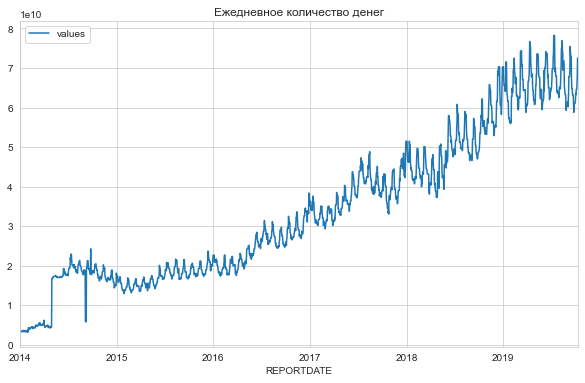

In [9]:
sns.set_style('whitegrid')
data.plot(title='Ежедневное количество денег', figsize=(10, 6))

Есть видимый провал в данных в середине 2014 года — в тот год был кризис, возможно люди резко начали снимать наличные средства.

Проведем ресэпмплирование по неделям

In [10]:
data_res = data.resample('1W').mean()

<AxesSubplot:title={'center':'Еженедельно количество денег'}, xlabel='REPORTDATE'>

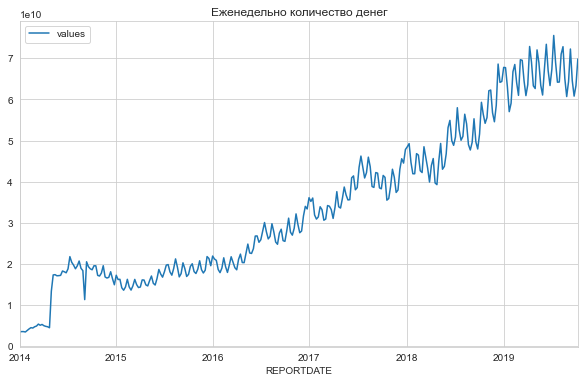

In [11]:
data_res.plot(title='Еженедельно количество денег', figsize=(10, 6))

In [12]:
data_res.head()

,values
REPORTDATE,
2014-01-05,3.422883e+09
2014-01-12,3.510315e+09
2014-01-19,3.503572e+09
2014-01-26,3.411524e+09
2014-02-02,3.797833e+09


### Сделаем разложение ряда на составляющие:

<Figure size 1080x720 with 0 Axes>

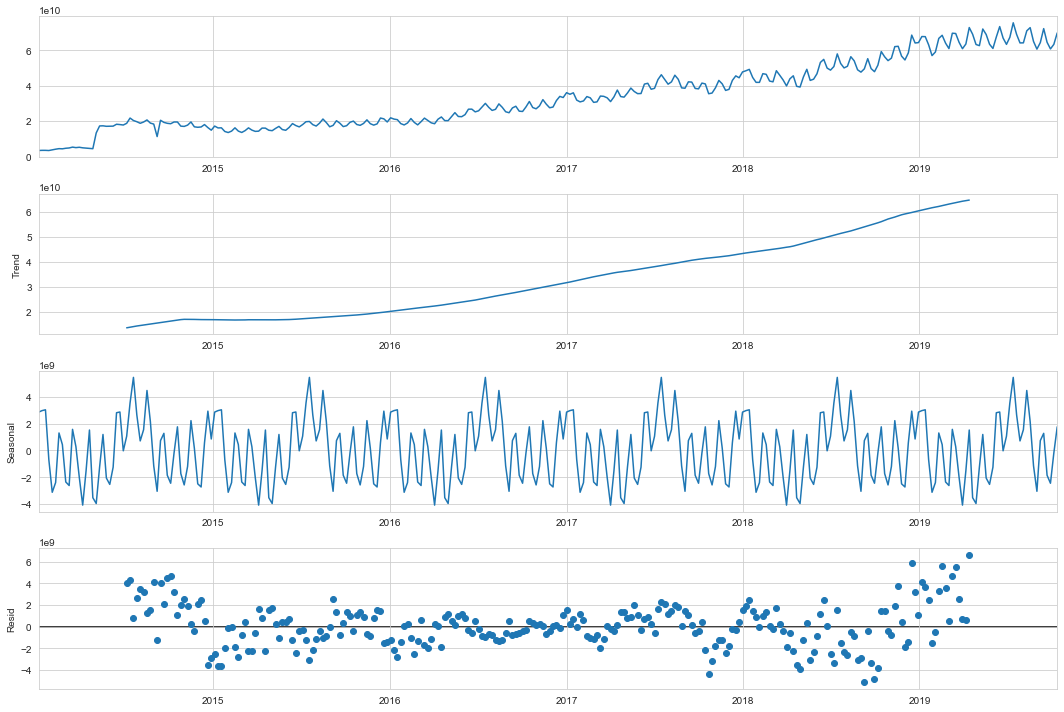

In [13]:
decomposed = seasonal_decompose(data_res)
plt.figure(figsize(15,10))
decomposed.plot();

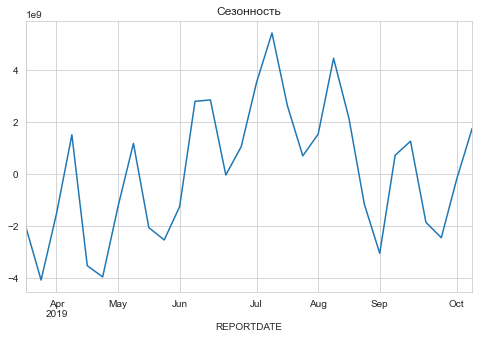

In [14]:
decomposed.seasonal.tail(30).plot(title='Сезонность', figsize=(8, 5));

Видно, что длина цикла составляет один год.

Посмотрим на остатки:

<AxesSubplot:title={'center':'Остатки'}, xlabel='REPORTDATE'>

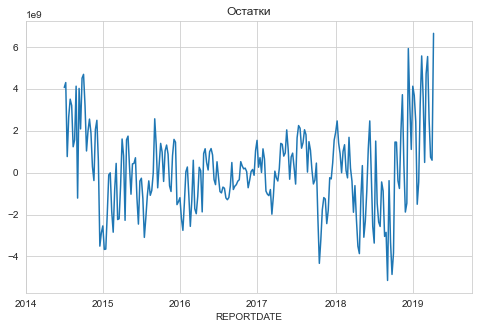

In [15]:
decomposed.resid.plot(title='Остатки', figsize=(8, 5))

### Проверка стационарности ряда

In [16]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data_res.values)[1])

Критерий Дики-Фуллера: p=0.919505


Гипотеза о стационарности критерием Дики-Фуллера отвергается.

### Стабилизация дисперсии
Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.486016
Критерий Дики-Фуллера: p=0.408358


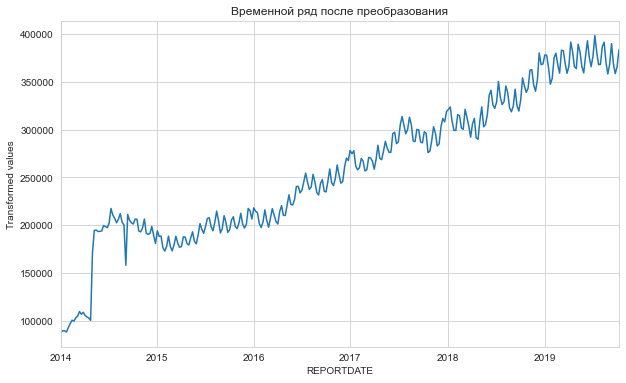

In [17]:
data_res['values_box'], lmbda = stats.boxcox(data_res['values'])

data_res.values_box.plot(title='Временной ряд после преобразования', figsize=(10, 6))
plt.ylabel(u'Transformed values')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data_res.values_box)[1])

Дисперсия стабилизировалась. Осталась нестационарность и сезонность.

## Выбор порядка дифференцирования

Попробуем применить сезонное дифференцирование.

In [18]:
data_res['values_box_diff'] = data_res.values_box - data_res.values_box.shift(53)

decomposed_diff = seasonal_decompose(data_res.values_box_diff[53:])

print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data_res.values_box_diff[53:])[1])

Критерий Дики-Фуллера: p=0.031719


Критерий Дики-Фуллера отвергает гипотезу нестационарности на уровне значимости 0,05

<AxesSubplot:title={'center':'Тренд'}, xlabel='REPORTDATE'>

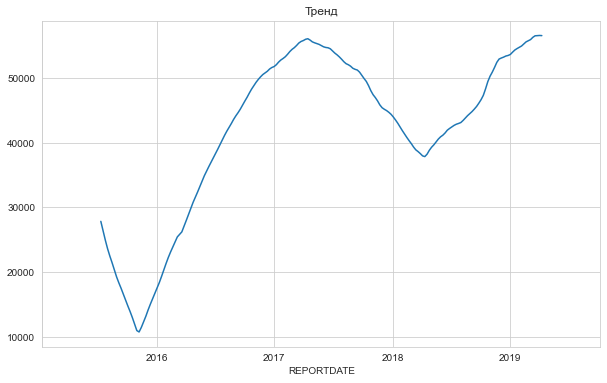

In [19]:
decomposed_diff.trend.plot(title='Тренд', figsize=(10, 6))

<Figure size 1080x720 with 0 Axes>

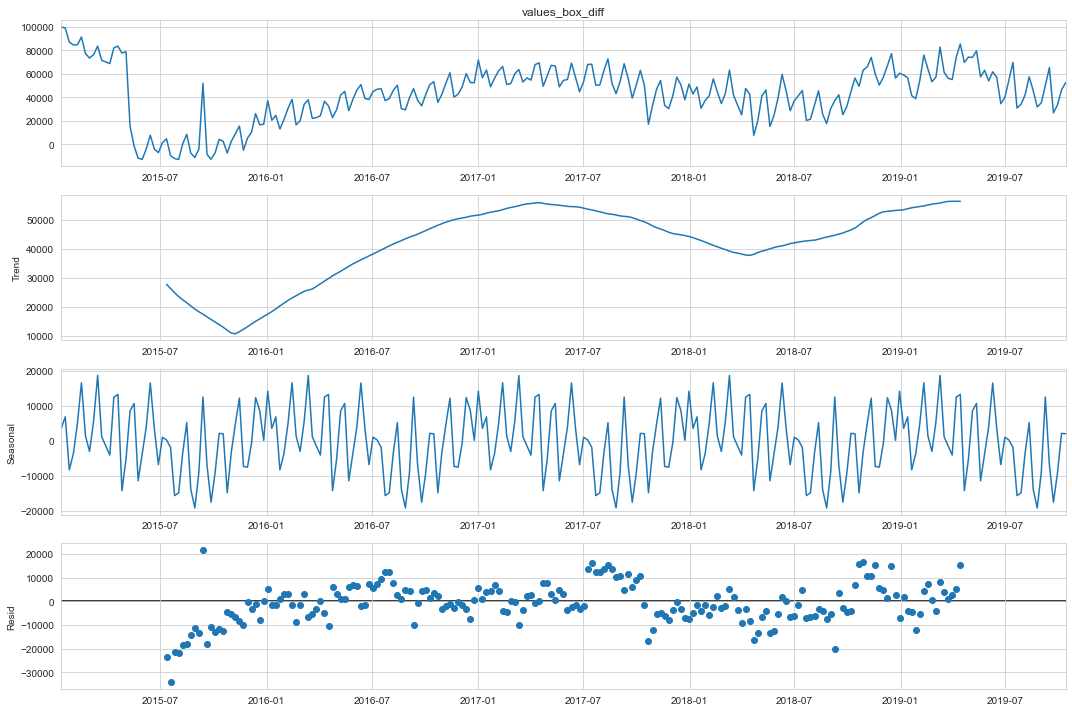

In [20]:
plt.figure(figsize(15,10))
decomposed_diff.plot();

<AxesSubplot:title={'center':'Тренд'}, xlabel='REPORTDATE'>

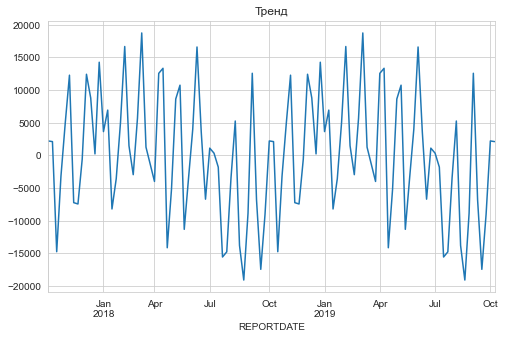

In [21]:
decomposed_diff.seasonal.tail(106).plot(title='Тренд', figsize=(8, 5))

В данных явно остался тренд, попробуем простое дифференцирование

In [22]:
data.head()

,values
REPORTDATE,
2013-12-30,3457625638
2013-12-31,3417092149
2014-01-01,3417092149
2014-01-02,3417092149
2014-01-03,3417092149


In [23]:
data_res['values_box_diff2'] = data_res.values_box_diff - data_res.values_box_diff.shift(1)

Критерий Дики-Фуллера: p=0.000053


<Figure size 1080x720 with 0 Axes>

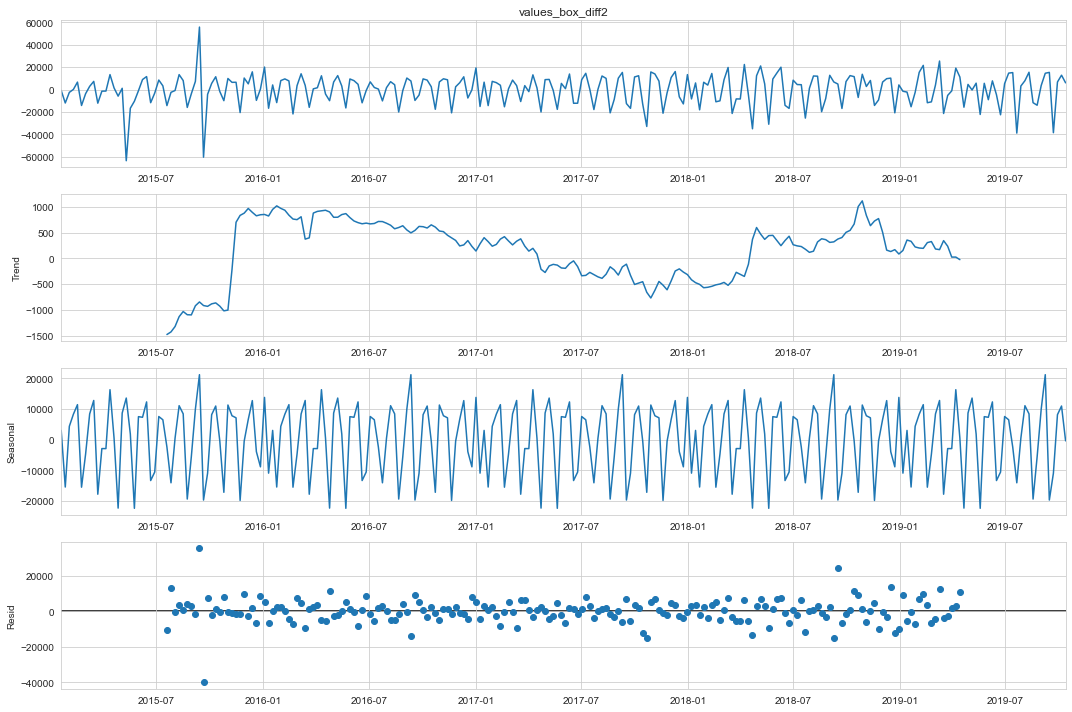

In [24]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data_res.values_box_diff2[54:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data_res.values_box_diff2[54:])[1])

Критерий Дики-Фуллера с уверенностью отвергает гипотезу нестационарности. Получившийся ряд - стационарный.

In [25]:
data.head()

,values
REPORTDATE,
2013-12-30,3457625638
2013-12-31,3417092149
2014-01-01,3417092149
2014-01-02,3417092149
2014-01-03,3417092149


### 4 Выбор начальных приближений для p, q, P, Q

Посмотрим на ACF и PACF полученного ряда:

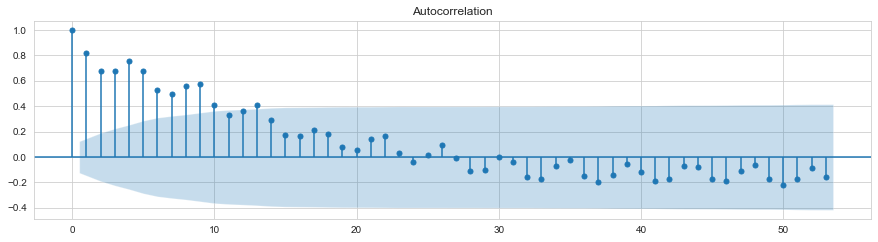

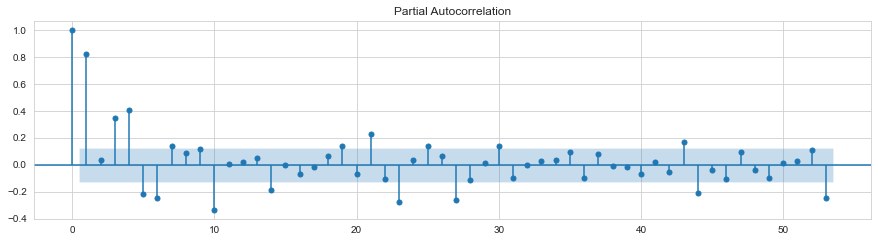

In [26]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data_res.values_box_diff[53:].values.squeeze(), lags=53, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data_res.values_box_diff[53:].values.squeeze(), lags=53, ax=ax)
pylab.show()

Начальные приближения: Q=0; q=1; P=1; p=10 (p<12)

In [27]:
ps = range(0, 11)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 1)

In [28]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

44

Сгенерируем признаки для дальнейшего обучения моделей:
- признак месяц: в течение года есть колебания;
- признак день в месяце - месячные колебания, связано с получением зарплаты и пополнением средств
- признак день недели - недельные колебания


### 5 Обучение и сравнение моделей-кандидатов, выбор победителя

In [29]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data_res.values_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 33.4 s


In [30]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters          aic
43  (10, 1, 1, 0)  6179.973819
41  (10, 0, 1, 0)  6180.866957
37   (9, 0, 1, 0)  6181.601755
39   (9, 1, 1, 0)  6182.143265
35   (8, 1, 1, 0)  6198.177399


In [31]:
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                           values_box   No. Observations:                  302
Model:             SARIMAX(10, 1, 1)x(1, 1, [], 12)   Log Likelihood               -3076.987
Date:                              Mon, 28 Nov 2022   AIC                           6179.974
Time:                                      21:52:27   BIC                           6227.637
Sample:                                  01-05-2014   HQIC                          6199.072
                                       - 10-13-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5359      0.285      1.877      0.060      -0.024       1.095
ar.L2         -0.11

### 6 Анализ остатков
Анализ остатков построенной модели, при необходимости — её модификация: если остатки получаются смещёнными, прогноз нужно скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения p, q, P, Q.

Критерий Стьюдента: p=0.907589
Критерий Дики-Фуллера: p=0.000000


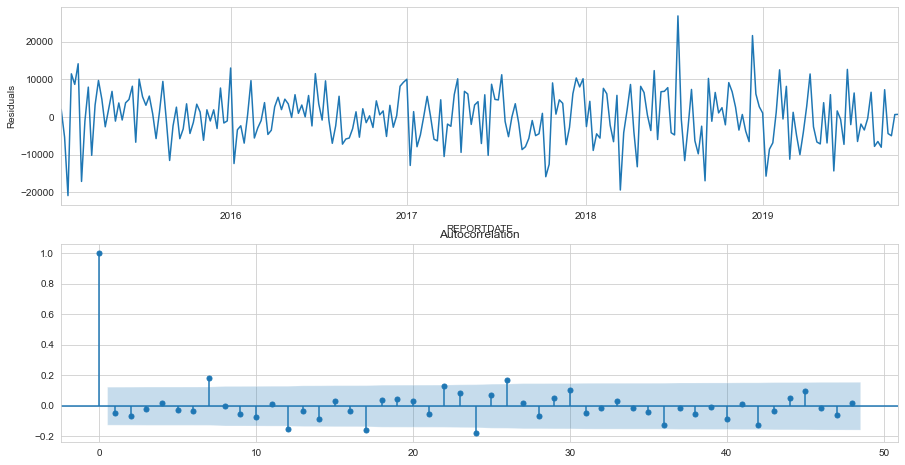

In [32]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[54:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[54:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[54:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[54:])[1])

Сравнение имеющихся данных с расчетными по модели

In [33]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

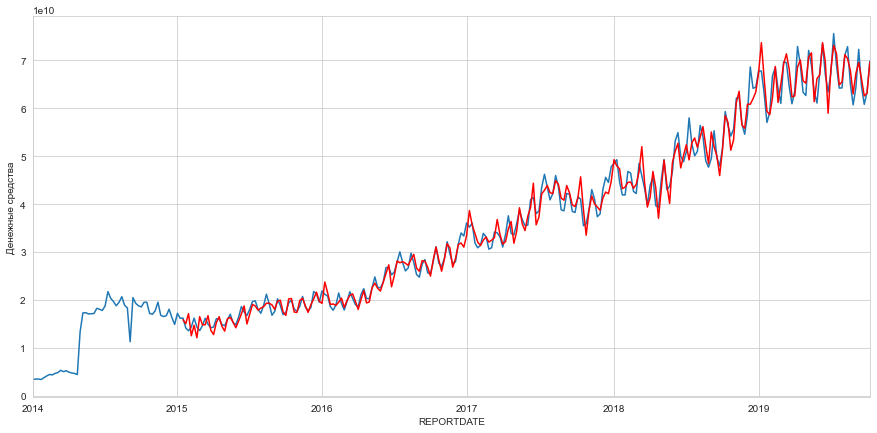

In [36]:
data_res['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data_res['values'].plot()
data_res.model[54:].plot(color='r')
plt.ylabel('Денежные средства')
plt.show()

In [37]:
data_res.tail()

,values,values_box,values_box_diff,values_box_diff2,model
REPORTDATE,,,,,
2019-09-15,7.227318e+10,389923.017488,65313.360719,15346.825225,6.953689e+10
2019-09-22,6.456505e+10,369125.354071,26778.387440,-38534.973279,6.615789e+10
2019-09-29,6.080820e+10,358525.628159,33550.427057,6772.039618,6.256030e+10
2019-10-06,6.337633e+10,365806.573525,46401.366309,12850.939252,6.314555e+10
2019-10-13,6.983502e+10,383473.467403,52421.297088,6019.930779,6.957435e+10


Сгенерируем даты на будущее, на год вперед:

In [38]:
len(data_res)

302

In [39]:
data2 = data_res[['values']]
date_list = [datetime.datetime.strptime("2019-10-13", "%Y-%m-%d") + relativedelta(weeks=x) for x in range(1,54)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=300, end=357), lmbda)

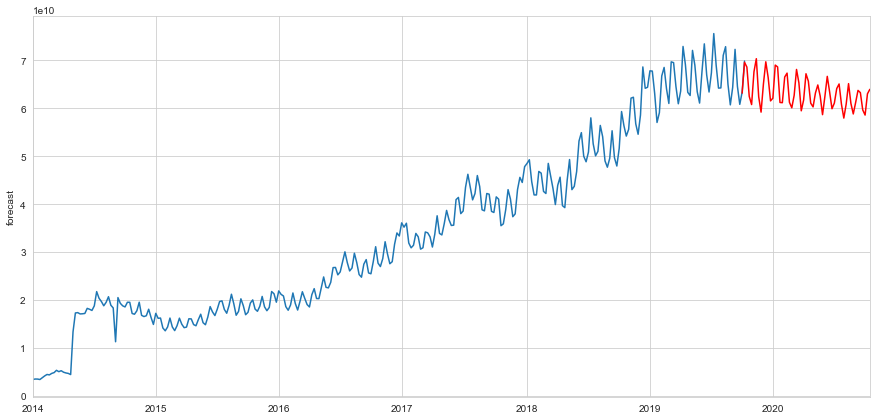

In [40]:
plt.figure(figsize(15,7))
data2['values'].plot()
data2['forecast'].plot(color='r')
plt.ylabel('forecast')
pylab.show()

In [41]:
data2.tail()

,values,forecast
2020-09-20,NaN,6.324808e+10
2020-09-27,NaN,5.964958e+10
2020-10-04,NaN,5.856902e+10
2020-10-11,NaN,6.300779e+10
2020-10-18,NaN,6.393559e+10


Вычислим скользящее среднеквадратичное отклонение с окном в 4 недели

In [42]:
data2['std'] = data2['forecast'].rolling(4).std()

Чтобы попать в 95% доверительный интервал, вычтем из прогнозируемой значения два стандартных отклонения:

In [43]:
data2['lower_forecast'] = data2['forecast'] - 2 * data2['std']

Наложим стандартное отклонение на график:

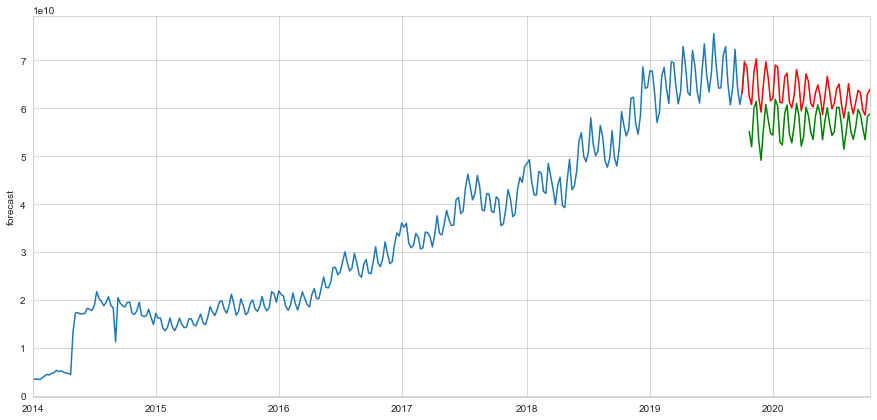

In [44]:
plt.figure(figsize(15,7))
data2['values'].plot()
data2['forecast'].plot(color='r')
data2['lower_forecast'].plot(color='g')
plt.ylabel('forecast')
pylab.show()

In [45]:
data2['date'] = data2.index
data2['year'] = data2['date'].dt.year
data2['month'] = data2['date'].dt.month

In [46]:
data2

,values,forecast,std,lower_forecast,date,year,month
2014-01-05,3.422883e+09,NaN,NaN,NaN,2014-01-05,2014,1
2014-01-12,3.510315e+09,NaN,NaN,NaN,2014-01-12,2014,1
2014-01-19,3.503572e+09,NaN,NaN,NaN,2014-01-19,2014,1
2014-01-26,3.411524e+09,NaN,NaN,NaN,2014-01-26,2014,1
2014-02-02,3.797833e+09,NaN,NaN,NaN,2014-02-02,2014,2
...,...,...,...,...,...,...,...
2020-09-20,NaN,6.324808e+10,2.245325e+09,5.875743e+10,2020-09-20,2020,9
2020-09-27,NaN,5.964958e+10,1.886937e+09,5.587571e+10,2020-09-27,2020,9
2020-10-04,NaN,5.856902e+10,2.571149e+09,5.342673e+10,2020-10-04,2020,10
2020-10-11,NaN,6.300779e+10,2.363761e+09,5.828027e+10,2020-10-11,2020,10


Запишем функцию для расчета прогнозного значения через 1 месяц, 2 месяца и так далее, до 12 месяцев:

In [47]:
def model_forecast(data, end_date = "2019-10-13", months_span = 1):
    
    current_data = datetime.datetime.strptime(end_date, "%Y-%m-%d")
    next_date = current_data + relativedelta(months = months_span)
    
    value = data.loc[(data['month'] == next_date.month) & (data['year'] == next_date.year)]['lower_forecast'].min()

    print("История до {}. Стабильная прибыль на период {} месяц составляет {}".format(end_date, months_span, value))
    print("Прогнозная дата:", next_date)
                                                                             


Пример прогноза

In [48]:
model_forecast(data2, months_span = 2)

История до 2019-10-13. Стабильная прибыль на период 2 месяц составляет 49130424346.15576
Прогнозная дата: 2019-12-13 00:00:00


### Заключение

1. Что делали с данными?

Провели ресэмплинг данных, как среднее значение за неделю, недельные колебания не учитывались

2. Что учитывали в модели?

Месячная и годовая сезонность

Судя по графику, где сравниваются прогнозные значения временного ряда и известные видно, что модель предсказывает не случайно и в целом учитывает тренд и сезонность.

3. Что сделано?

На основе выбранной модели сделан прогноз временного ряда на год вперед, с частотой прогноза 1 неделя.

По заданию, нужно прогнозировать минимальный уровень денежных средств каждый месяц. Было рассчитано скользящее среднеквадратичное отклонение по 4 неделям и из пронозируемого уровня денежных средств отняли двойное отклонение, тем самым мы получили 95% доверительный интервал.

Сейчас прогноз немного упрощенный, модель выдает минимальное значение за текущий месяц.

4. Что можно доработать?

Поработать с настройкой модели, улучшить качество предсказания. Доработать функцию, чтобы была возможность предсказывать на конкретную дату, с шагом в одну неделю.